In [1]:
import pandas as pd

#Loading Dataset
df = pd.read_csv("./datasets/legal_text_classification.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors


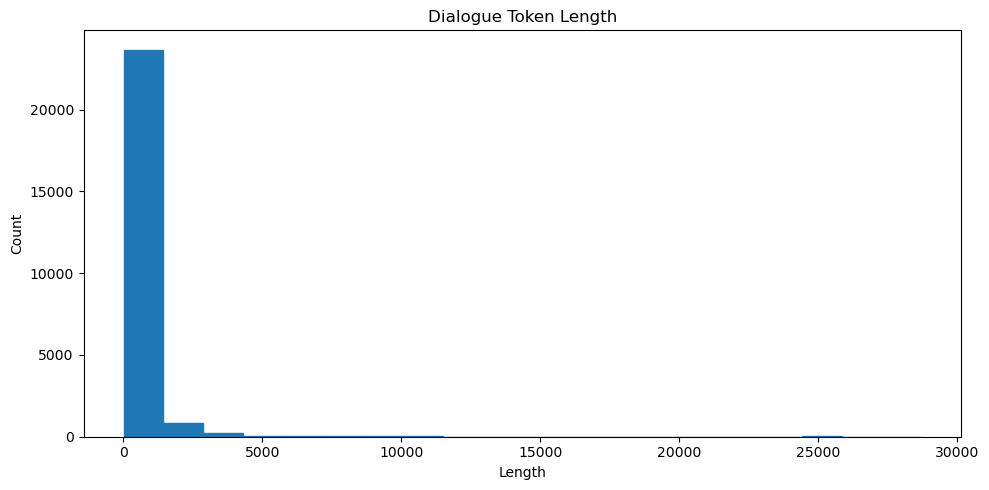

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# base model
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "nlpaueb/legal-bert-small-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  

# plotting sentences lenghth distribution (in terms of token)
d_len = [len(tokenizer.encode(str(s))) for s in df["case_text"]]

fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
axes.hist(d_len, bins=20, color="C0", edgecolor="C0")
axes.set_title("Dialogue Token Length")
axes.set_xlabel("Length")
axes.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [3]:
from datasets import Dataset, DatasetDict

def preprocess_data(df):
    
    #adding token_lenght column
    df["lb_num_token"] = d_len
    
    #Dropping Nan values
    df = df.dropna(subset=['case_text'])

    # Dropping unused features and renaming columns
    df = df.drop(columns =['case_id', 'case_title'])
    df.rename(columns={"case_text":"text", "case_outcome":"label"}, inplace= True)

    # Get the number of unique labels
    labels_list = df["label"].unique().tolist()
    
    # Splitting Dataset
    df = Dataset.from_pandas(df)
    df = df.map(lambda example: {'text': str(example['text'])})
    train_valid = df.train_test_split(test_size= 0.2, seed= 42)
    valid_test  = train_valid["test"].train_test_split(test_size= 0.5, seed= 42)
    
    df_split = DatasetDict({
    'train': train_valid['train'],
    'valid': valid_test['train'],
    'test': valid_test['test']
    })
    
    return df_split, labels_list

In [4]:
#splitting in training and test set
from datasets import Dataset, ClassLabel

# preprocessing dataset
df, labels_list = preprocess_data(df)

train = df["train"]
valid = df["valid"]
test  = df["test"]

Map:   0%|          | 0/24809 [00:00<?, ? examples/s]

In [5]:
import time
from transformers import AutoModel, AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from sklearn.metrics import f1_score

In [ ]:
def summarize_pegasus_long(tokenizer, model_sum, sample):
    summary = ""
    
    # summary token lenght condition
    d_len = len(tokenizer.encode(sample))
    
    if(d_len > 1024):
    
    # Summaries of long documents
        start = 0
        window_size = 1024
        total_len = d_len
        loop = True
    
        while loop:
            end = start + window_size
            if end >= total_len:
                loop = False
                end = total_len
                
            # (1) extract window from sample and tokenize it
            input_chuck_tokenizer = tokenizer.encode(sample[start:end+1], return_tensors='pt',max_length=1024,truncation=True).to(device)    
            # (2) summarize chunk
            with torch.no_grad():
                summary_chunck = model_sum.generate(input_chuck_tokenizer,
                                      num_beams=9,
                                      no_repeat_ngram_size=3,
                                      length_penalty=2.0,
                                      min_length=50,
                                      max_length=100,
                                      early_stopping=True)
                
            # (3) concatenate summaries
            summary = summary + "\n" + [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_chunck][0]       
            start = end
    else:
        # single summary
        input_tokenized = tokenizer.encode(sample, return_tensors='pt',max_length=1024,truncation=True).to(device)    
        with torch.no_grad():
            summary_ids = model_sum.generate(input_tokenized,
                                          num_beams=9,
                                          no_repeat_ngram_size=3,
                                          length_penalty=2.0,
                                          min_length=150,
                                          max_length=400,
                                          early_stopping=True)
        
        summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
    return {"text" : summary }

def summarizing_samples(df):
    print(df)
    model_ckpt_sum = "nsi319/legal-pegasus"
    tokenizer_sum = AutoTokenizer.from_pretrained(model_ckpt_sum)
    model_sum = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt_sum).to(device)
    
    df_long = df.filter(lambda example: example["lb_num_token"] > 512)
    df_short= df.filter(lambda example: example["lb_num_token"] <= 512)

    df_long = df_long.map(lambda example: summarize_pegasus_long(tokenizer_sum, model_sum, example["text"]), batched = False)
                                                                                          
    df = concatenate_datasets([df_long, df_short])
    print(df)
    return df

# Record the start time
start_time = time.time()

# Summarize trasformer model
device = "cuda" if torch.cuda.is_available() else "cpu"

# Call your function
train = summarizing_samples(train)
valid = summarizing_samples(valid)
test = summarizing_samples(test)

# Record the end time
end_time = time.time()

# Execution time in Minutes
execution_time = (end_time - start_time)/60
print("Execution Time:", execution_time, "minutes")

Dataset({
    features: ['label', 'text', 'lb_num_token', '__index_level_0__'],
    num_rows: 19847
})


Filter:   0%|          | 0/19847 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19847 [00:00<?, ? examples/s]

Map:   0%|          | 0/5570 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1561 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1": f1}

def legalbert_last_hiddenstate_fe(data, tokenizer_sum , label_list):
    
    if str(type(data)) ==  "<class 'dict'>":
        data = Dataset.from_dict(data)
        print(data)
        
    # Transformer settings
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'GPU on: {torch.cuda.is_available()}')
    model_ckpt= 'nlpaueb/legal-bert-small-uncased'
    #trained_model = './tmp/run-10/checkpoint-11500'
    
    # Loading model and tokenaizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    model = AutoModel.from_pretrained(model_ckpt, num_labels = len(labels_list)).to(device)
    
    print("GPU memory allocated before tokenization", torch.cuda.memory_allocated()/(1024**3))
    

    
    #tokenizing samples
    def tokenization(batch):
        #tokenize text
        tokenized_sample = tokenizer(batch["text"][i], padding=True, truncation=True, max_length=512, return_tensors= "pt").to(device)
        
        #encode label
        labels = ClassLabel(names=labels_list)
        tokenized_sample["label"] = labels.str2int(batch["label"])
        
        return tokenized_sample
    
    
    data_token = data.map(tokenization, batched=True, batch_size = 5)
    print("Done tokenization")
    print("GPU memory allocated after tokenization", torch.cuda.memory_allocated()/(1024**3))
    torch.cuda.empty_cache()
    
    
    #mapping inputs
    def extract_hidden_state(batch, device = "cpu"):
        model.to("cpu")
        inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
        # Retriving last hidden state
        with torch.no_grad():
            last_hidden_state = model(**inputs).last_hidden_state
        
        return {"hidden_state": last_hidden_state[:,0]}
    
    
    data_token.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    
    data_hidden = data_token.map(extract_hidden_state, batched = True)
    
    print("Done hidden state")
    
    return data_hidden

In [ ]:
# Record the start time
start_time = time.time()

# Summarize trasformer model
device = "cuda" if torch.cuda.is_available() else "cpu"

# Call your function
train = legalbert_last_hiddenstate_fe(train, tokenizer_sum,labels_list)
valid = legalbert_last_hiddenstate_fe(valid, tokenizer_sum, labels_list)
test  = legalbert_last_hiddenstate_fe(test[0:5], tokenizer_sum, labels_list)

# Record the end time
end_time = time.time()

# Execution time in Minutes
execution_time = (end_time - start_time)/60
print("Execution Time:", execution_time, "minutes")

In [ ]:
import numpy as np

#creating a features matrix
x_train = np.array(train["hidden_state"])
x_valid = np.array(valid["hidden_state"])
x_test  = np.array(test["hidden_state"])
y_train = np.array(train["label"])
y_valid = np.array(valid["label"])
y_test = np.array(test["label"])

In [ ]:
from sklearn.linear_model import LogisticRegression

# training softmax regression
clf = LogisticRegression(random_state=0, multi_class="multinomial").fit(x_train, y_train)
y_pred = clf.predict(x_valid)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

#confusion matrix
def plot_confusion_matrix(y_pred, y_true, labels_list):
    cm = confusion_matrix(y_true, y_pred, normalize= "true")
    fig, ax = plt.subplots(figsize=(11,11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels_list)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar= False)
    plt.title("Normalized confusion Matrix")
    plt.show()

# Confusion Matrix plot
plot_confusion_matrix(y_pred, y_valid, labels_list)